<a href="https://colab.research.google.com/github/Shreeranjita1222/Envision-Project/blob/main/Helmet_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 12509, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 12509 (delta 30), reused 27 (delta 9), pack-reused 12448
Receiving objects: 100% (12509/12509), 12.24 MiB | 27.98 MiB/s, done.
Resolving deltas: 100% (8622/8622), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 8.0 MB/s 
Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 145 kB 8.2 MB/s 
     |████████████████████████████████| 178 kB 66.6 MB/s 
     |████████████████████████████████| 3.1 MB 57.9 MB/s 
     |████████████████████████████████| 1.1 MB 63.5 MB/s 
     |████████████████████████████████| 21.8 MB 1.1 MB/s 
     |████████████████████████████████| 67 kB 7.8 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 138 kB 74.0 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
roboflow 0.2.7 req

In [ ]:
%cd /content
!curl -L "https://app.roboflow.com/ds/pXAo2q7dmx?key=oBFHn95WC3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2842      0 --:--:-- --:--:-- --:--:--  2842
100 19.2M  100 19.2M    0     0  21.2M      0 --:--:-- --:--:-- --:--:--  362M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/BikesHelmets104_png.rf.cea791bf17bb81545441bc856b745326.jpg  
 extracting: test/images/BikesHelmets116_png.rf.a91f7b8dcf9b9ca663aafe9c03b8efca.jpg  
 extracting: test/images/BikesHelmets133_png.rf.6bc731a56cb6cacb815f3c78d2be77f3.jpg  
 extracting: test/images/BikesHelmets143_png.rf.28482726db171074c442b6f7b8c2b0aa.jpg  
 extracting: test/images/BikesHelmets148_png.rf.aa90a2f3aa1155025c401527e58c8746.jpg  
 extracting: test/images/BikesHelmets170_png.rf.5e3e8058fd

In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")

/content/yolov5


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['With Helmet', 'Without Helmet']

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 12467, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 12467 (delta 7), reused 10 (delta 3), pack-reused 12447
Receiving objects: 100% (12467/12467), 12.21 MiB | 33.17 MiB/s, done.
Resolving deltas: 100% (8598/8598), done.


In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 1500 --data '/content/yolov5/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

Streaming output truncated to the last 5000 lines.
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 4/4 [00:00<00:00,  6.66it/s]
                 all         124         256       0.657       0.632       0.626       0.332

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
  502/1499     1.43G   0.02537   0.01009  0.001369   0.03683        18       416: 100% 28/28 [00:03<00:00,  7.38it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 4/4 [00:00<00:00,  6.24it/s]
                 all         124         256       0.713       0.582       0.609       0.314

     Epoch   gpu_mem       box       obj       cls     total   targets  img_size
  503/1499     1.43G   0.02352  0.009869  0.001227   0.03462        15       416: 100% 28/28 [00:03<00:00,  7.28it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 4/4 [00:

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

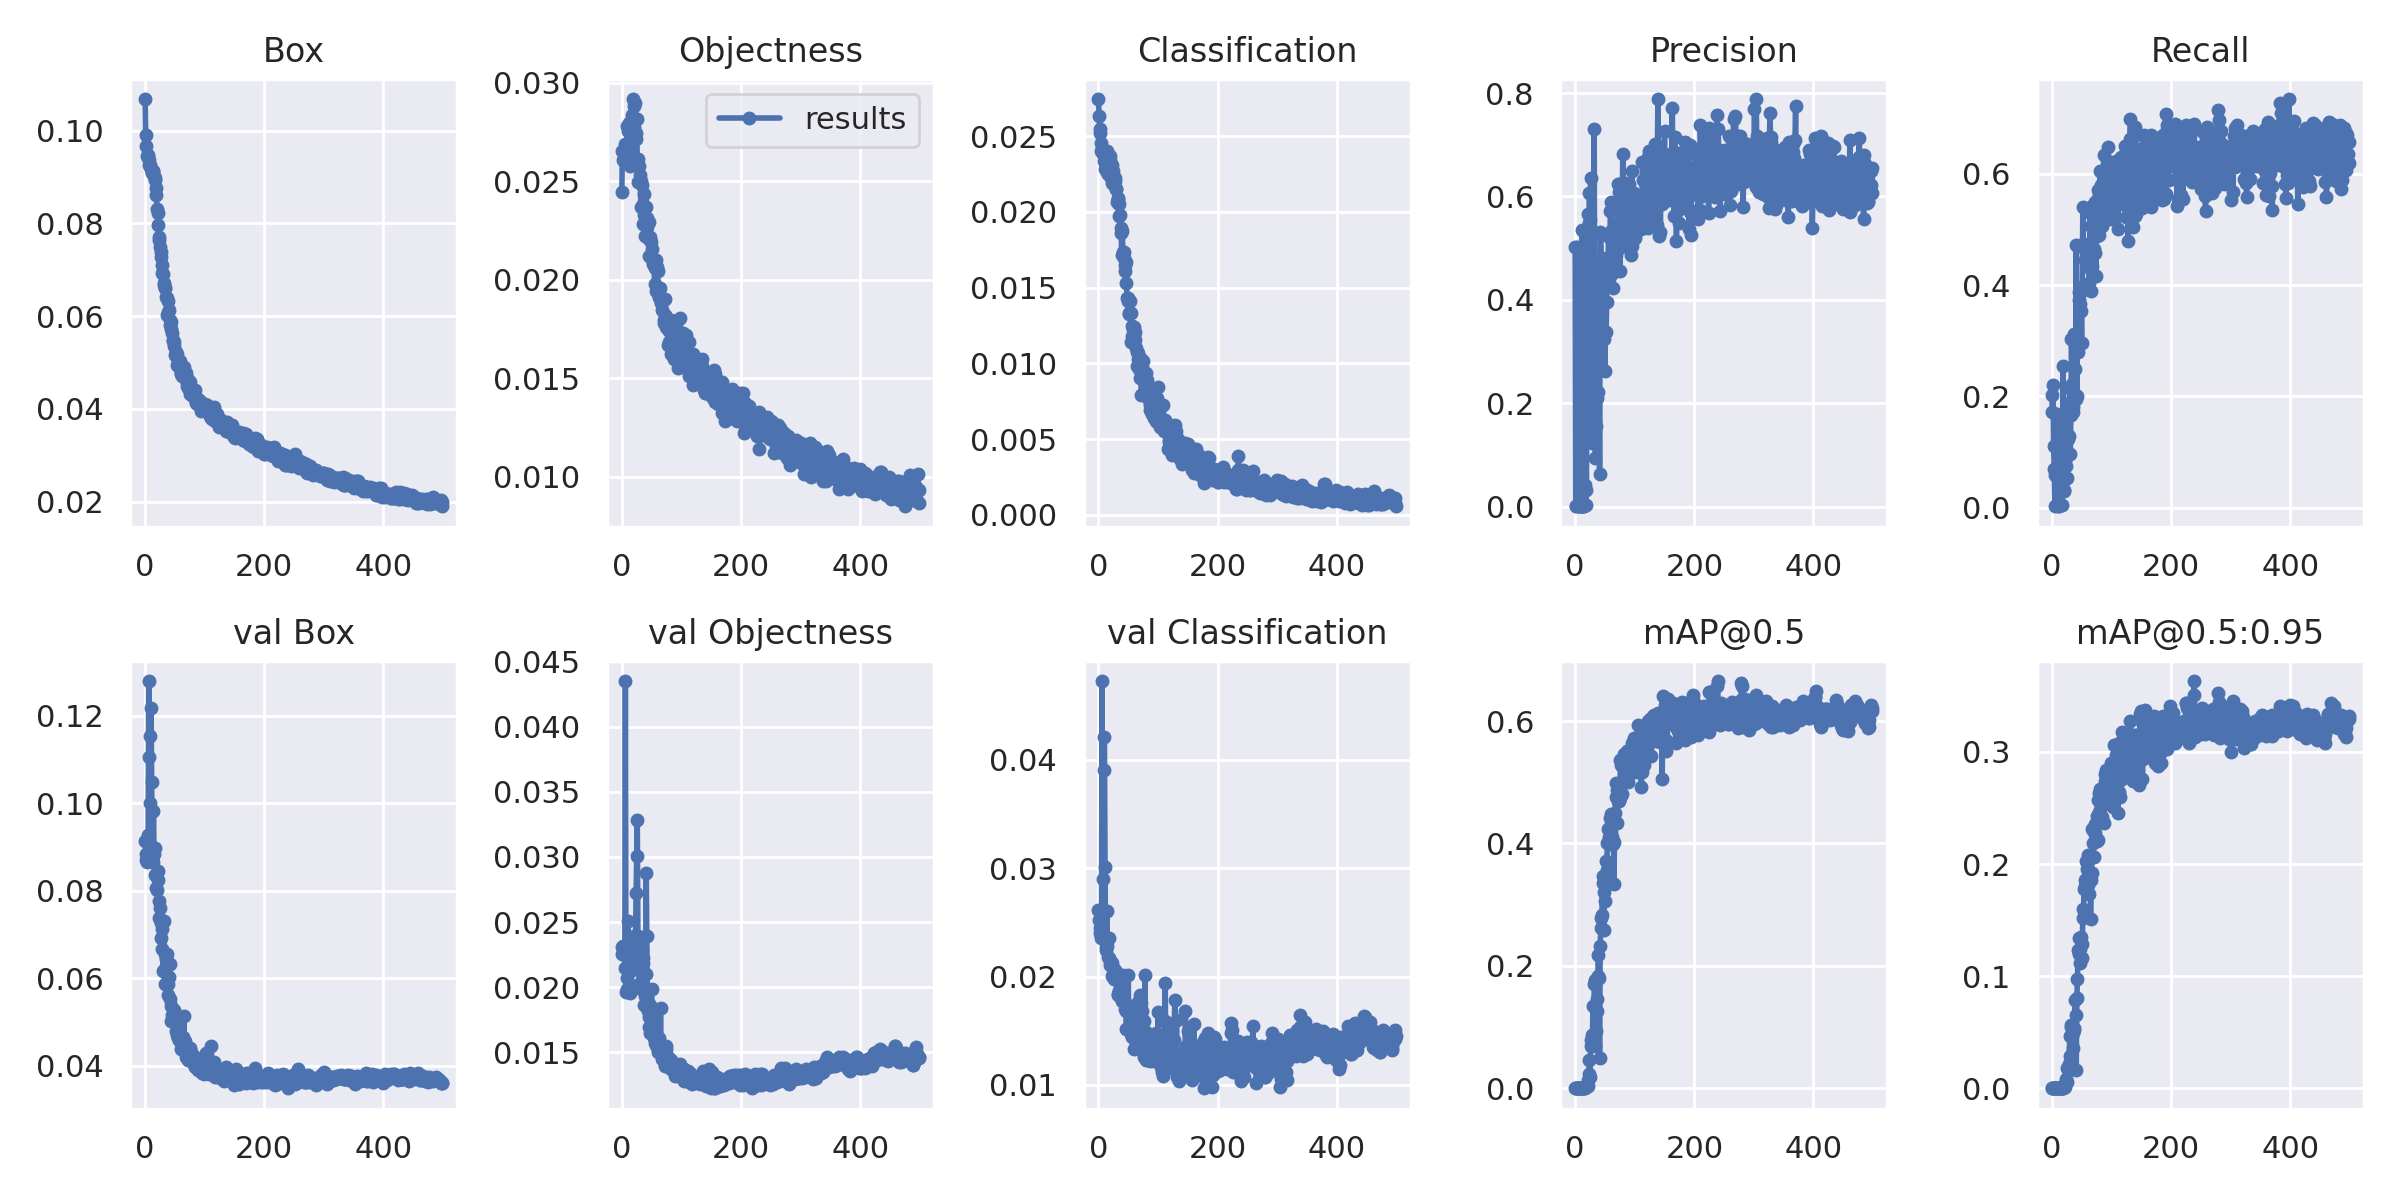

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


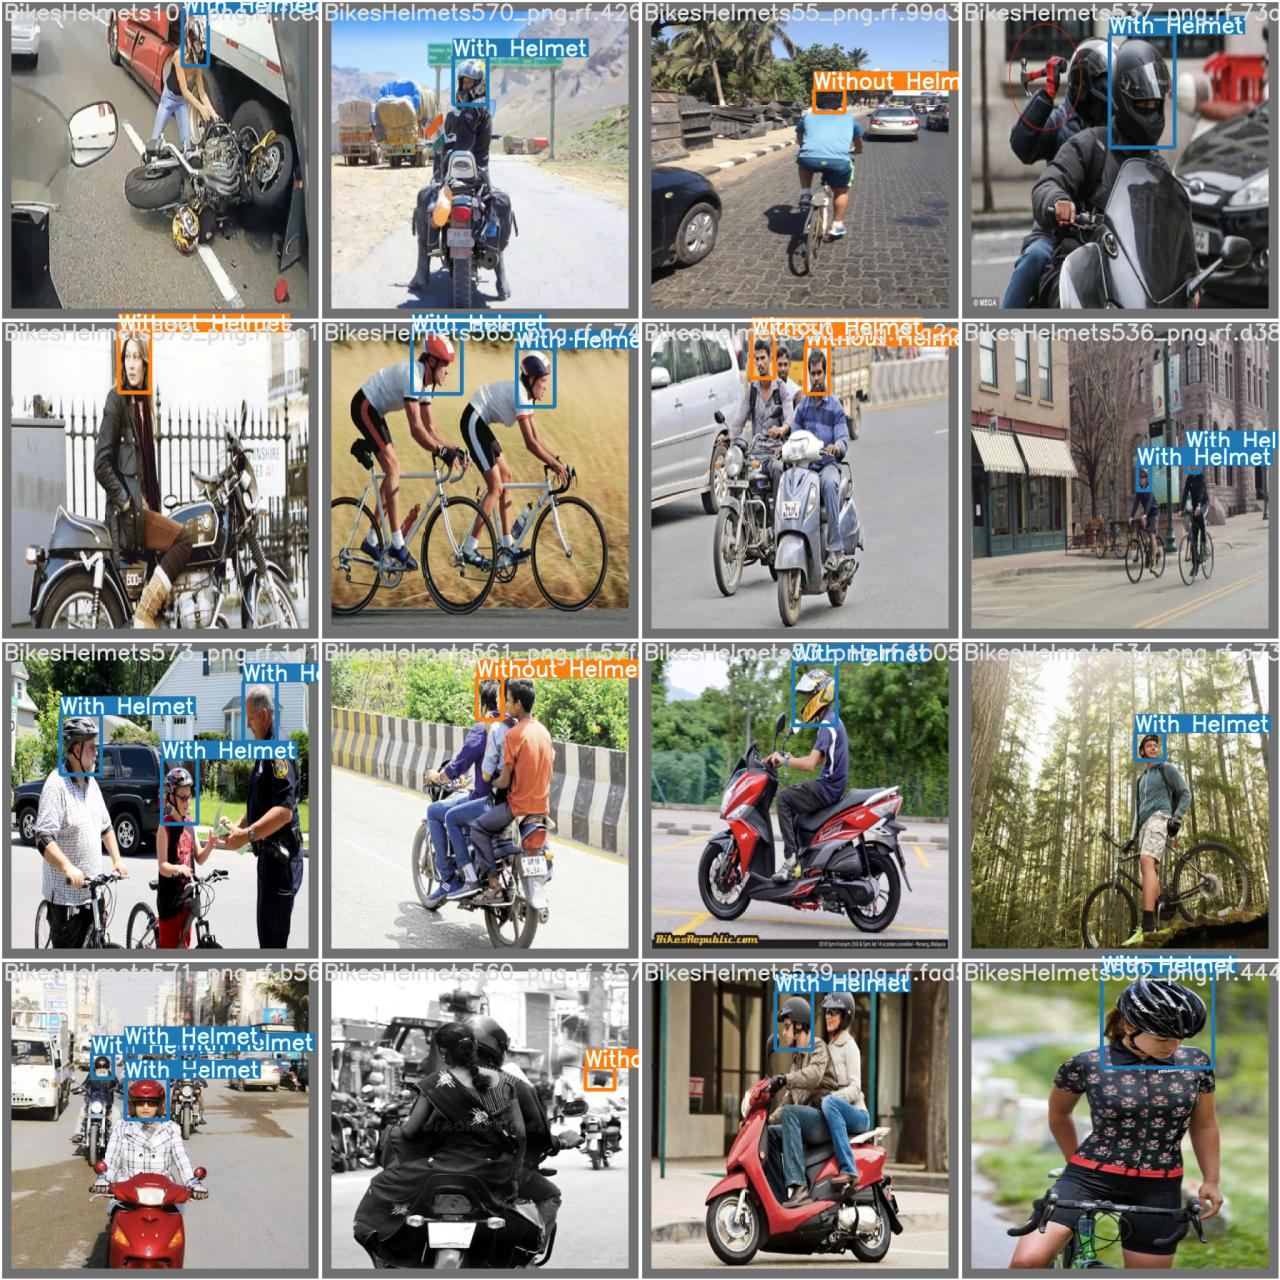

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


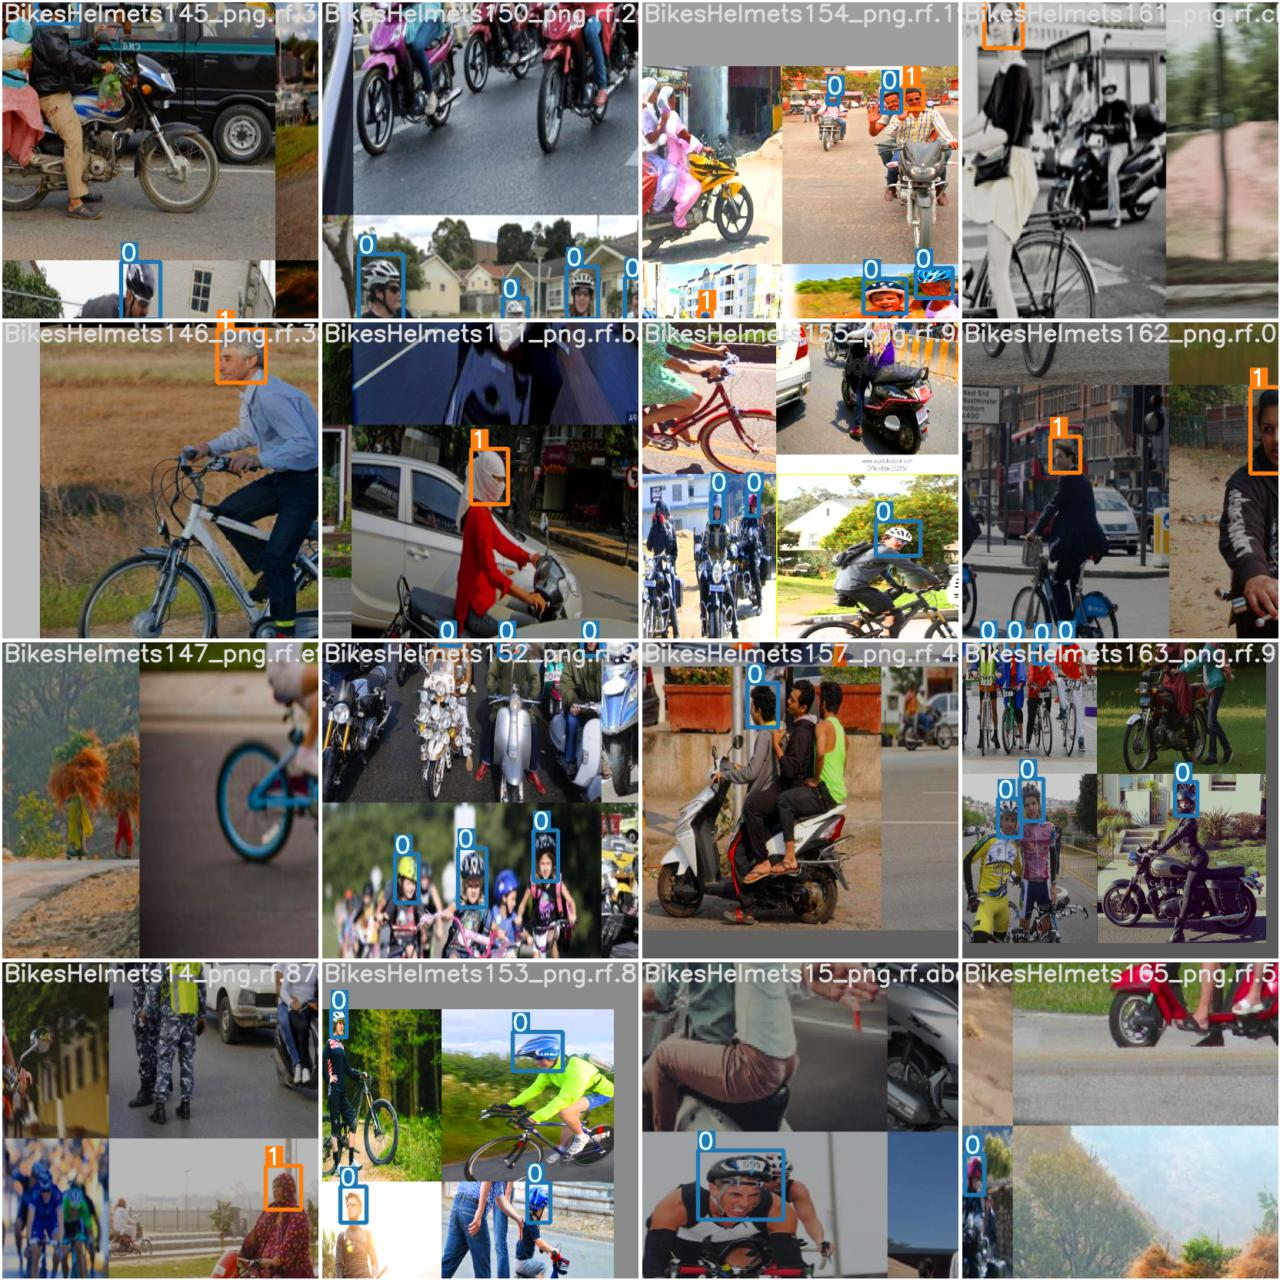

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch2.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls /content/yolov5/weights/download_weights.sh

/content/yolov5/weights/download_weights.sh*


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.11.0+cu113 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.7 GFLOPS
image 1/65 /content/test/images/BikesHelmets104_png.rf.cea791bf17bb81545441bc856b745326.jpg: 416x416 2 With Helmets, Done. (0.021s)
image 2/65 /content/test/images/BikesHelmets116_png.rf.a91

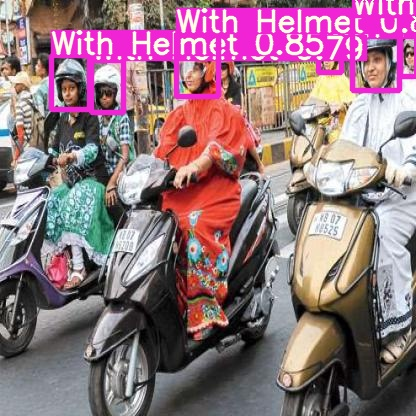

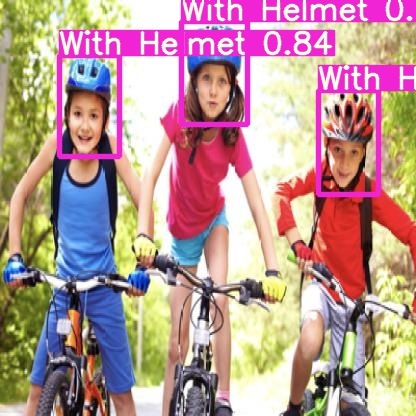

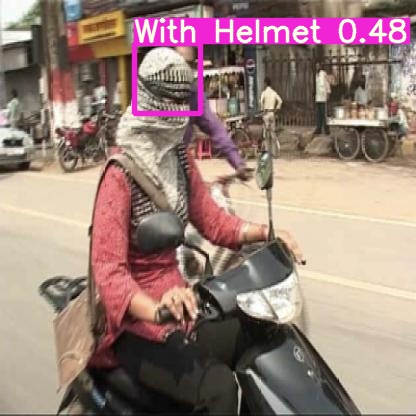

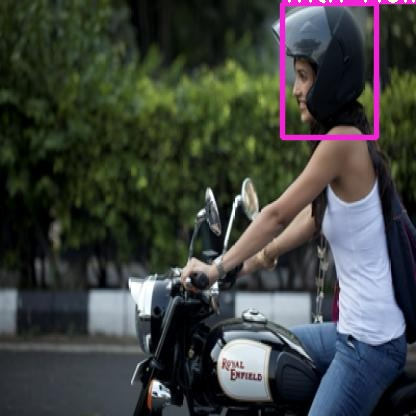

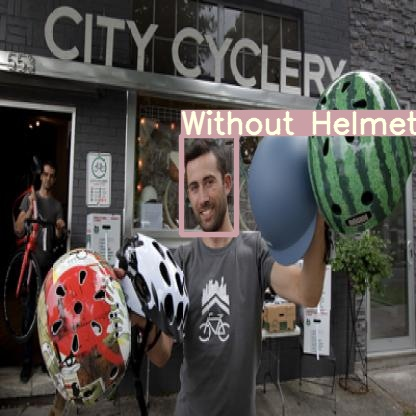

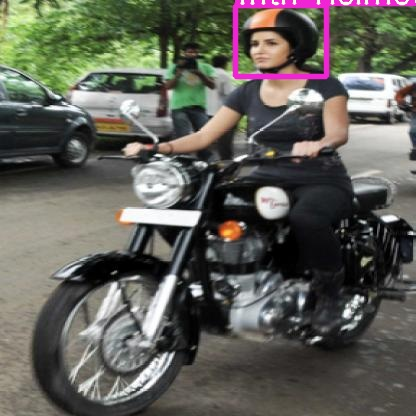

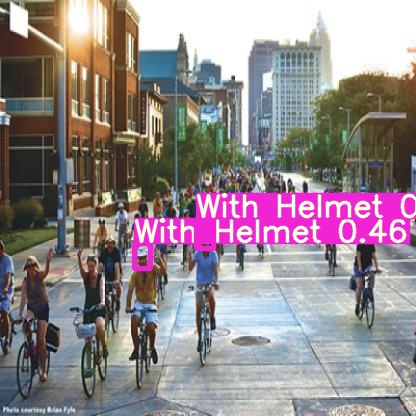

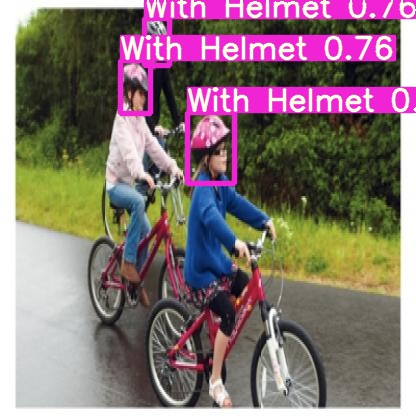

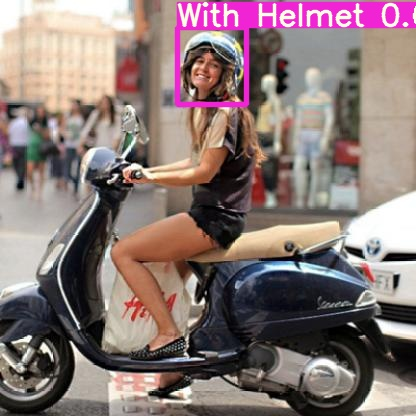

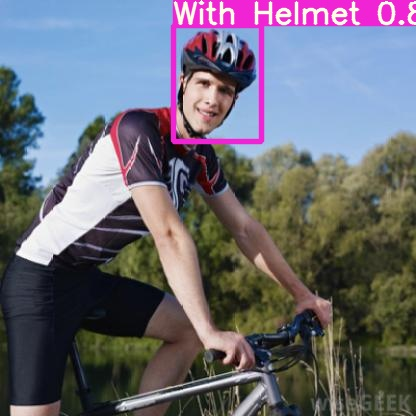

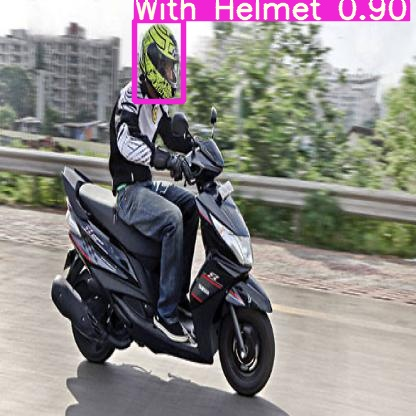

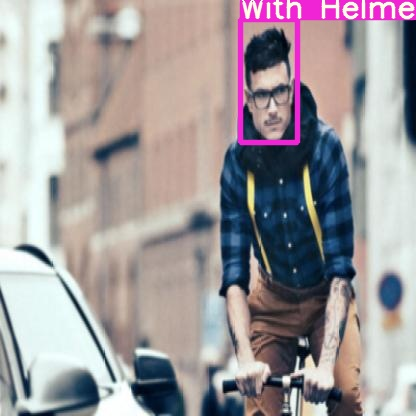

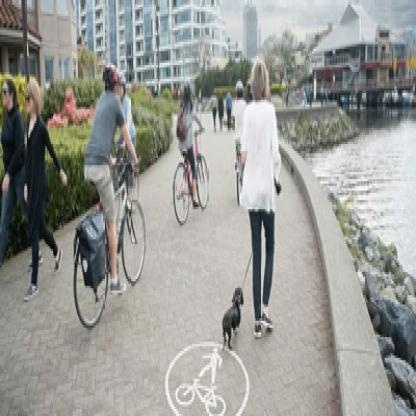

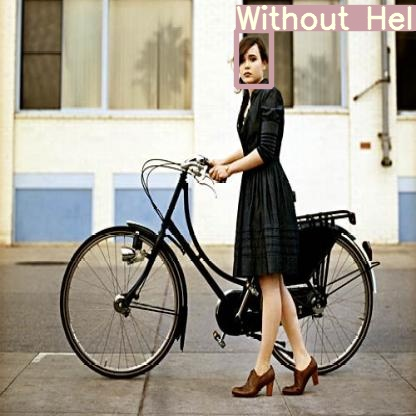

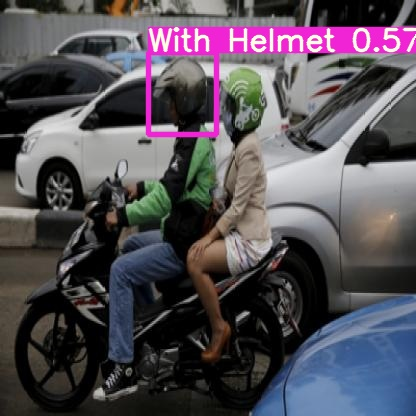

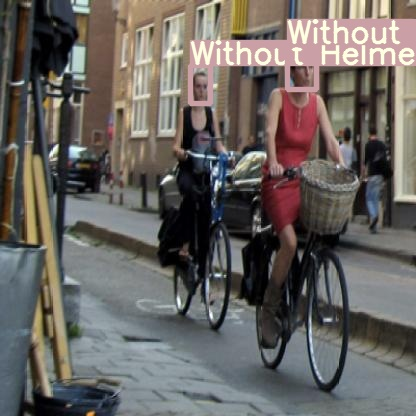

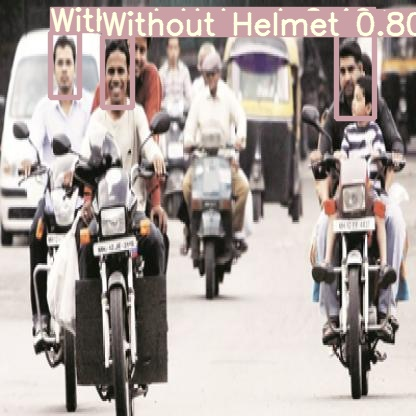

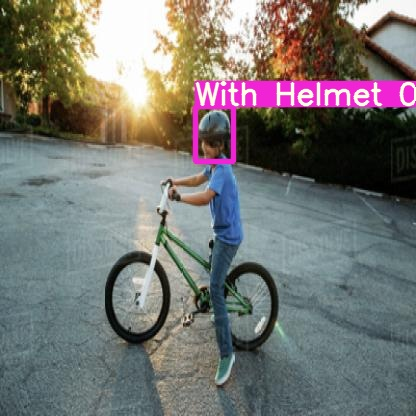

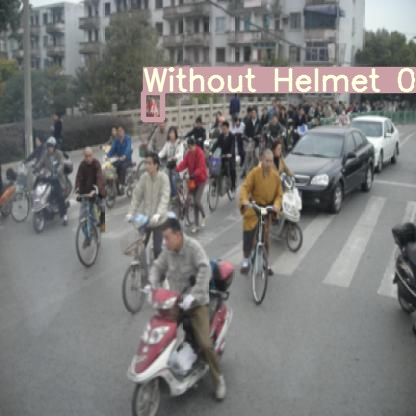

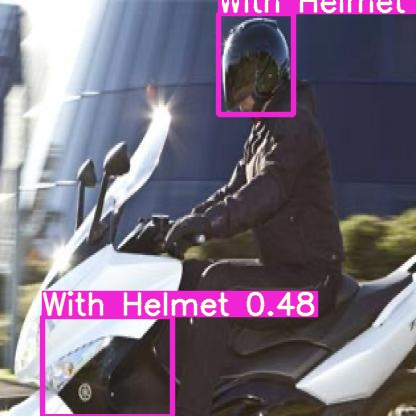

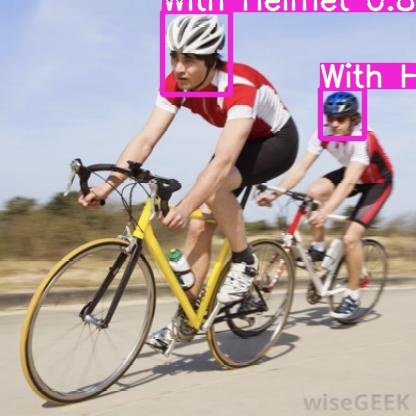

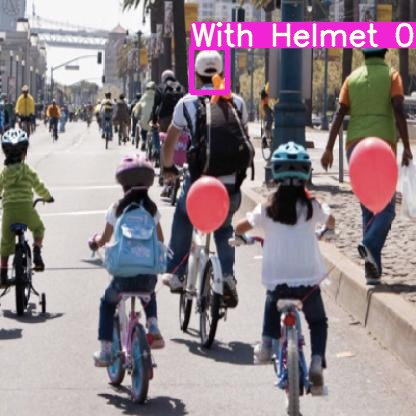

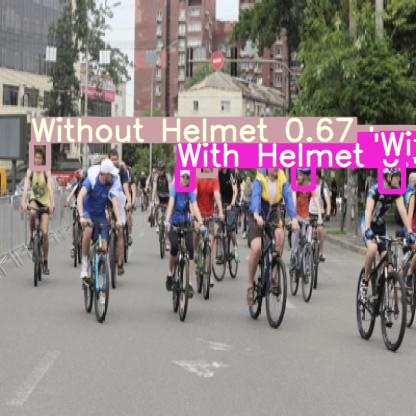

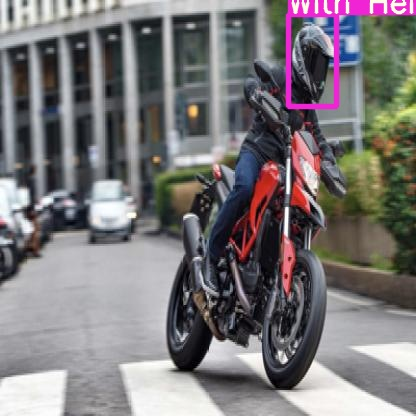

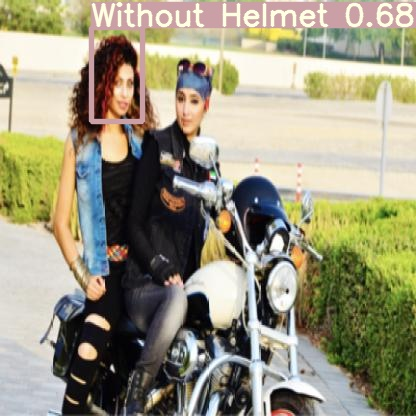

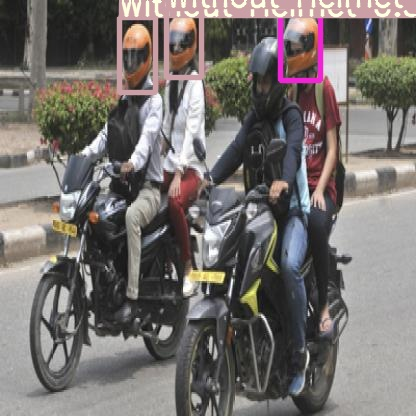

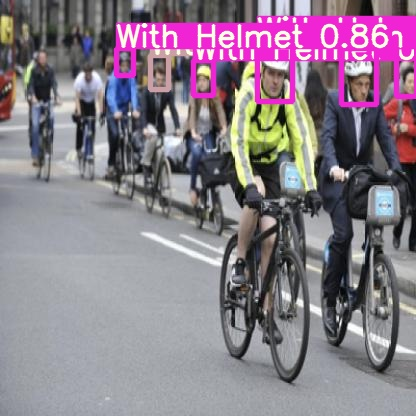

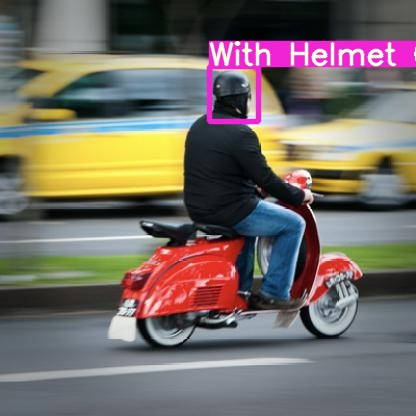

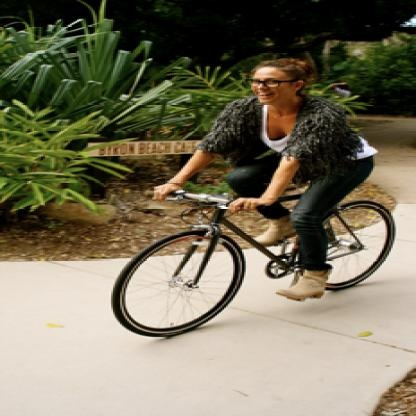

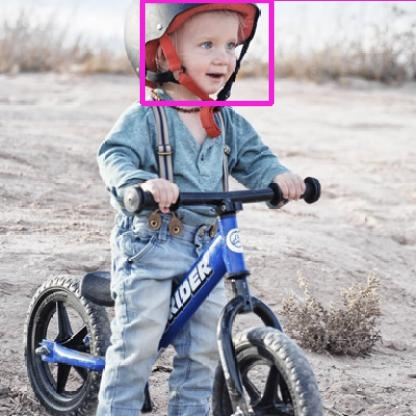

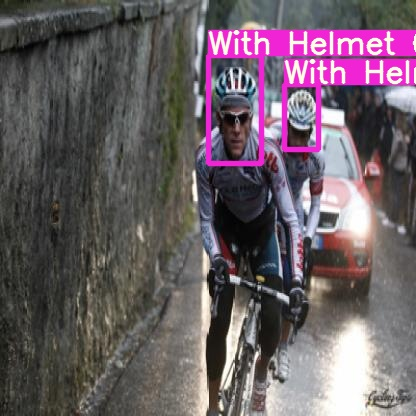

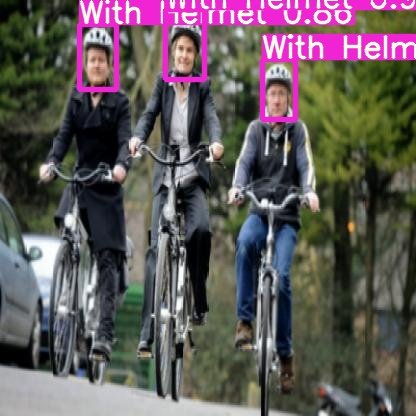

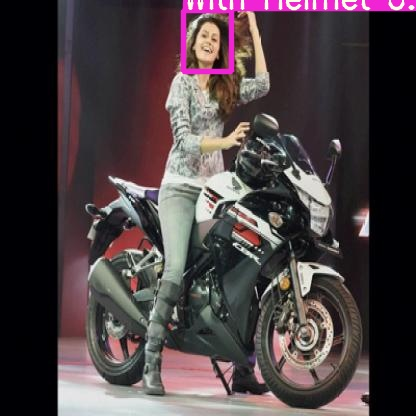

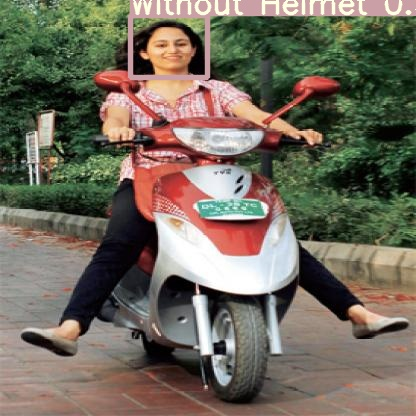

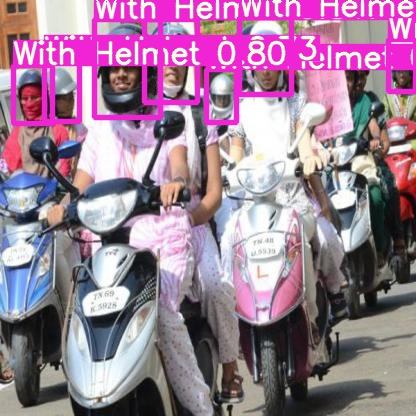

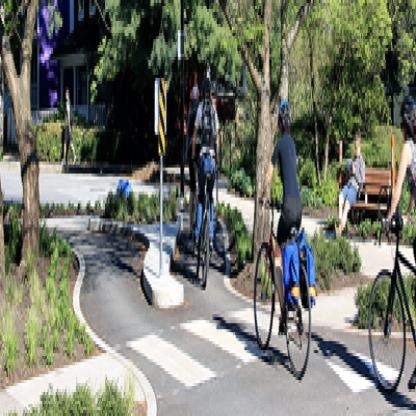

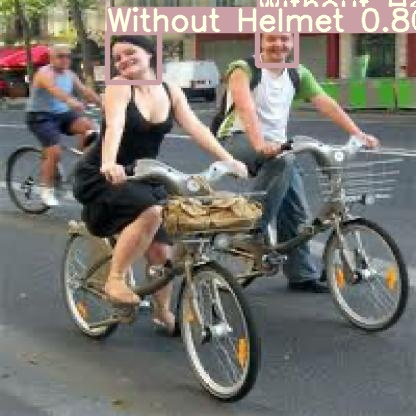

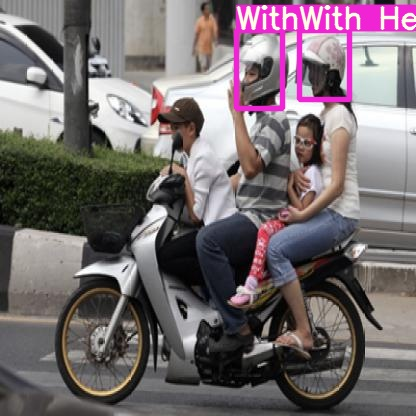

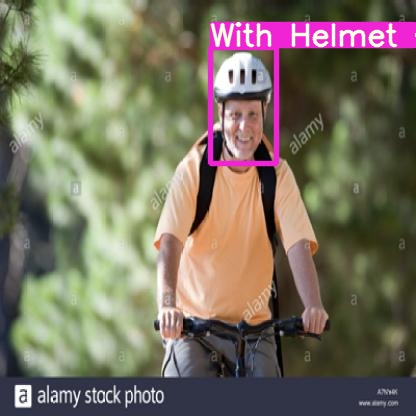

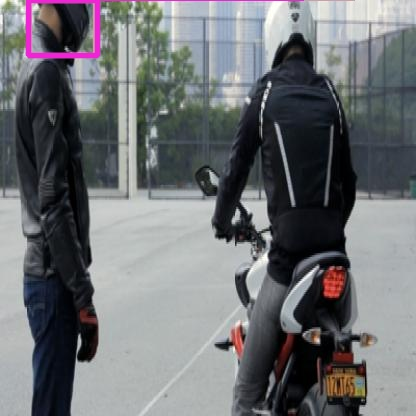

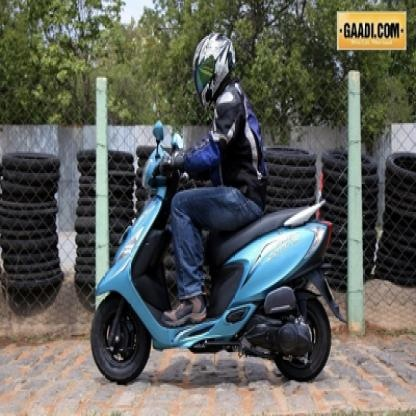

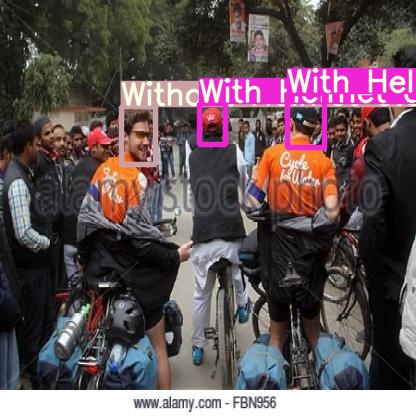

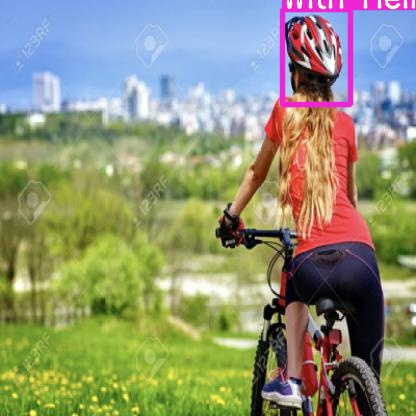

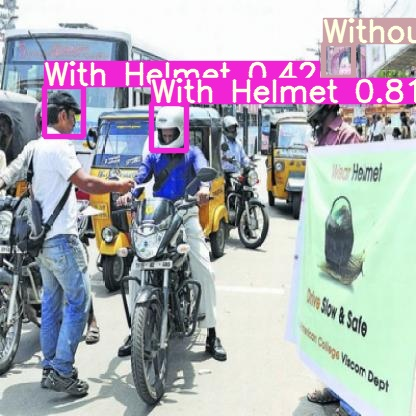

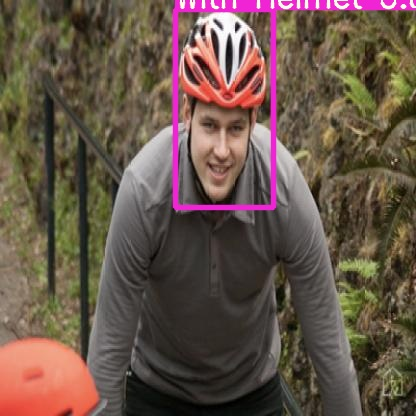

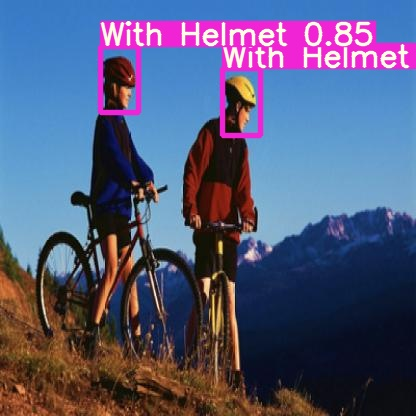

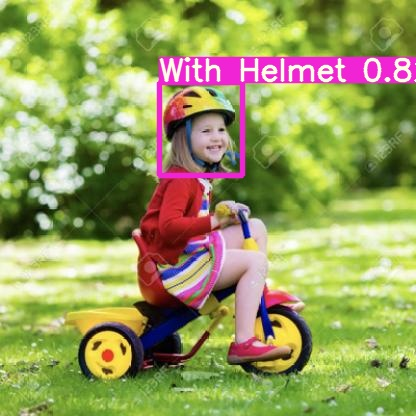

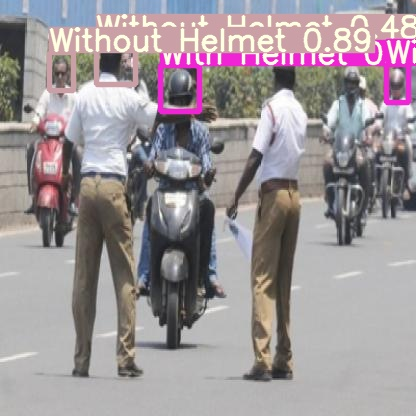

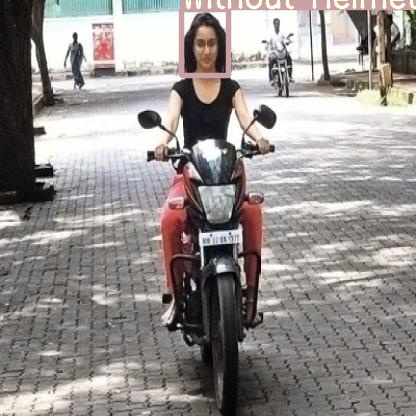

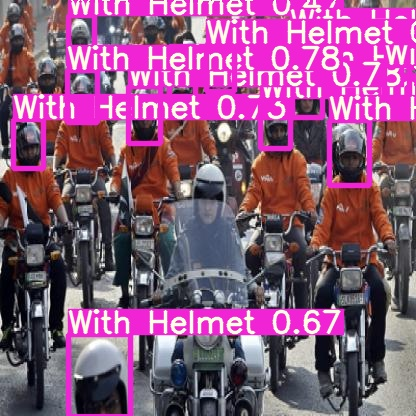

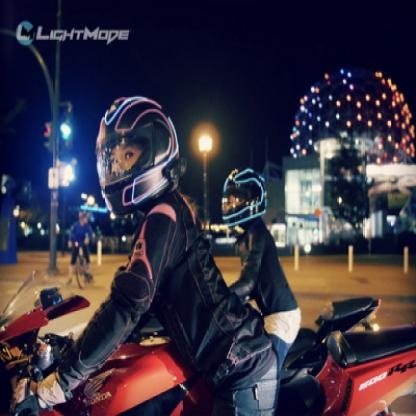

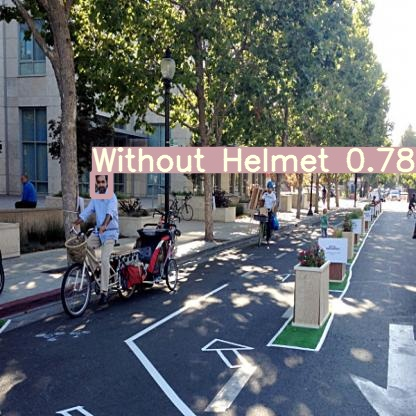

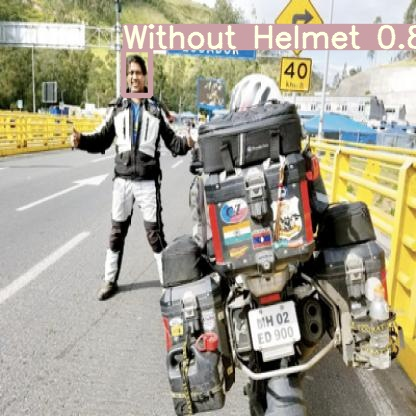

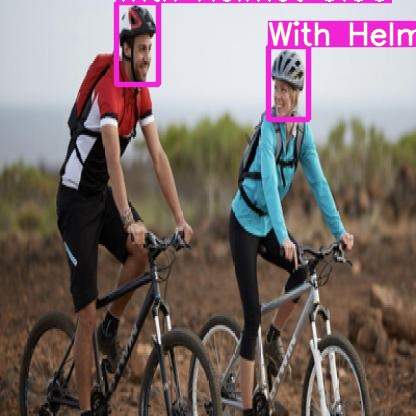

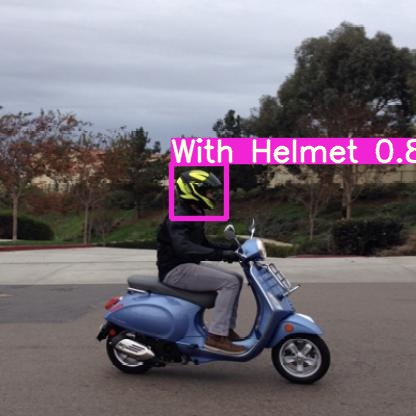

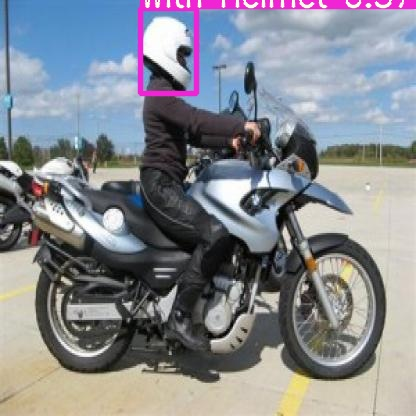

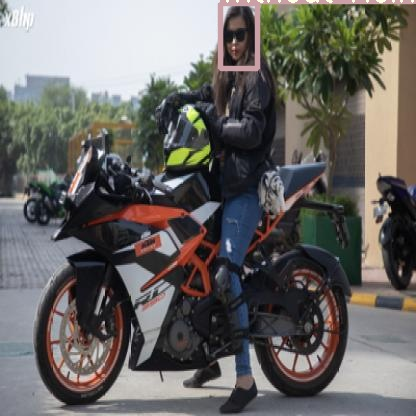

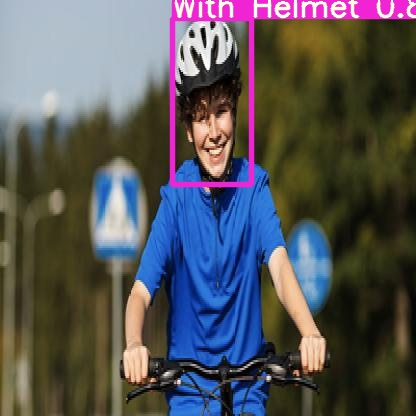

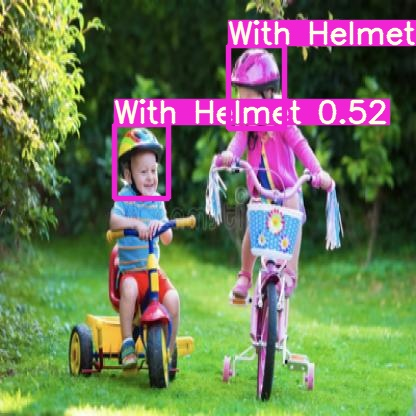

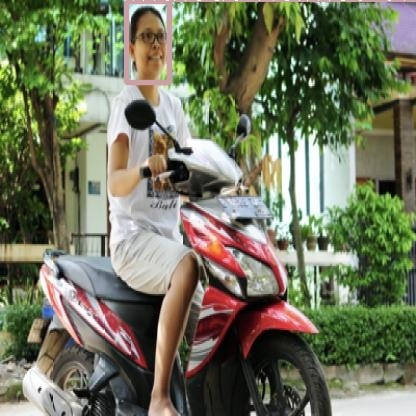

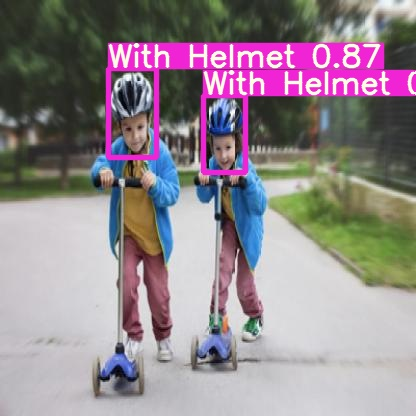

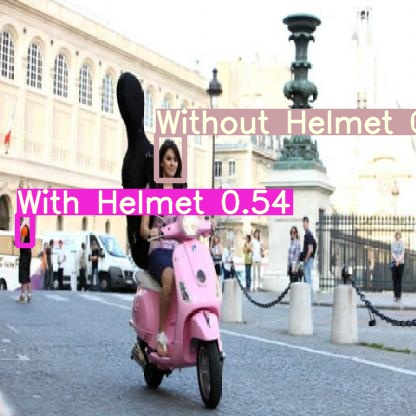

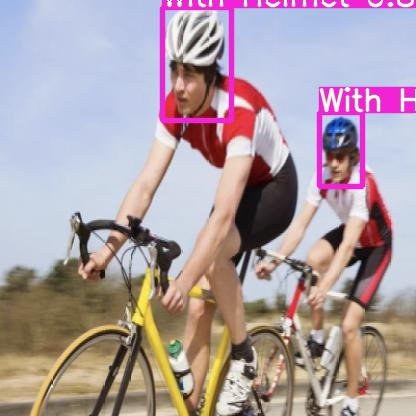

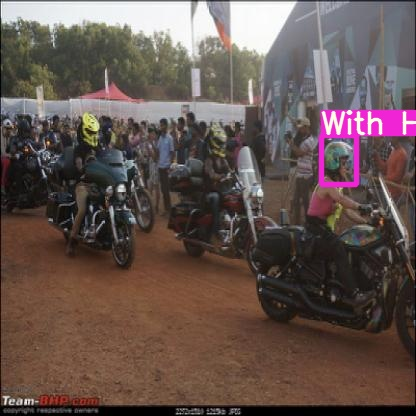

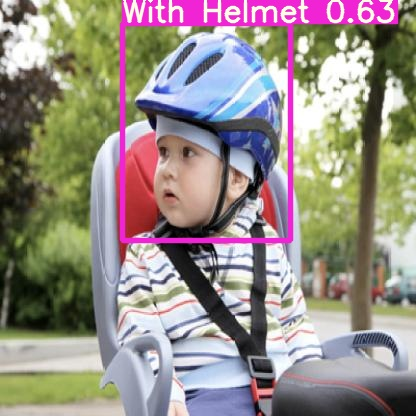

In [ ]:
 #display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
import cv2

In [ ]:
import cv2
from darkflow.net.build import TFNet
import numpy as np
import time

options = {
    'model': '/content/yolov5/models/custom_yolov5s.yaml',
    'load': '/content/yolov5/weights/download_weights.sh',
    'threshold': 0.1,
    'label': '/content/yolov5/data.yaml'
}

tfnet = TFNet(options)
colors = [tuple(255 * np.random.rand(3)) for _ in range(10)]

capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while True:
    stime = time.time()
    ret, frame = capture.read()
    if ret:
        results = tfnet.return_predict(frame)
        for color, result in zip(colors, results):
            tl = (result['topleft']['x'], result['topleft']['y'])
            br = (result['bottomright']['x'], result['bottomright']['y'])
            label = result['label']
            confidence = result['confidence']
            text = '{}: {:.0f}%'.format(label, confidence * 100)
            frame = cv2.rectangle(frame, tl, br, color, 5)
            frame = cv2.putText(
                frame, text, tl, cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2)
        cv2.imshow('frame', frame)
        print('FPS {:.1f}'.format(1 / (time.time() - stime)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
cv2.destroyAllWindows() 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive